<a href="https://colab.research.google.com/github/tujiaqi2002/DL_lab1/blob/main/Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1eBLPoRsr0F81ruy_t5eAHYNqVjzGm0w7?usp=sharing

Github Link:

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

CUDA is not available.  Training on CPU ...


In [7]:
# Helper function from lab2
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices


def get_data_loader(target_classes, batch_size, data_path):
    """ Loads images of gestures, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')

    
    # Transform Settings 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the dataset
    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(dataset, classes, target_classes)
    
    # Split into train, validation, and test
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    train_split = int(len(relevant_indices) * 0.6) # Split at 60%
    val_split = int(len(relevant_indices) * 0.2) # Split at 20%
    
    train_indices = relevant_indices[:train_split]
    val_indices = relevant_indices[train_split:train_split+val_split]
    test_indices = relevant_indices[train_split+val_split:]

    # Create data samplers for train, validation, and test sets
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders for train, validation, and test sets
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader, classes

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [8]:
# data path of dataset
data_path = '/content/gdrive/MyDrive/Colab Notebooks/Lab3_Gestures_Summer'

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], 
    batch_size=1, data_path = data_path) # One image per batch



In [9]:
total_data = len(train_loader) + len(val_loader) + len(test_loader)

print("The number of training images is", len(train_loader), ", which is", len(train_loader)/total_data*100, "% of the entire dataset.")
print("The number of validation images is", len(val_loader), ", which is", len(val_loader)/total_data*100, "% of the entire dataset.")
print("The number of test images is", len(test_loader), ", which is", len(test_loader)/total_data*100, "% of the entire dataset.")

The number of training images is 1333 , which is 59.99099909990999 % of the entire dataset.
The number of validation images is 444 , which is 19.98199819981998 % of the entire dataset.
The number of test images is 445 , which is 20.027002700270028 % of the entire dataset.


For the whole dataset, I split the dataset into 60% for training 20% validation and 20% for testing.

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [33]:
class CNN(nn.Module):
    # My CNN has 2 covolutional layers and 2 fully connected layers
    # pooling layes is using max-pooling with size of 2x2
    # Using Relu activation function

    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5) #input channel = 3; output channel = 5; kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5) #input channel = 5; output channel = 10; kernel size = 5
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9) #32 hidden units, 9 outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [59]:
def get_accuracy(model, train_loader, valid_loader, train):
    if train:
        data = train_loader
    else:
        data = valid_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [95]:
def train(model, train_loader,  val_loader, batch_size=128, learning_rate=0.001, num_epochs=20):
    train_loader = train_loader
    val_loader = val_loader
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model,train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model,train_loader, val_loader, train=False))  # compute validation accuracy
        print("epoch", epoch+1, "| accuracy: ",train_acc[epoch], " | validation accuracy", val_acc[epoch])

        # save the model
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

I chose Adam optimizer and cross entropy less function since they are commonly used for image processing. Cross entropy less function is works for multi-class problems and Adam converges faster and more robust to noisy gradients.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [67]:
def get_accuracy_small(model, train_loader):
    data = train_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [91]:
def train_small(model, batch_size=64, learning_rate=0.001, num_epochs=1):
    # data path of dataset
    small_data_path = '/content/gdrive/MyDrive/Colab Notebooks/small_data'

    # Transform Settings 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    small_dataset = torchvision.datasets.ImageFolder(root=small_data_path, transform=transform)
    
    small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=27, num_workers=1, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc = [], [], []

    # training
    for epoch in range(num_epochs):
        for imgs, labels in iter(small_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_small(model,small_loader)) # compute training accuracy
        print("epoch", epoch+1, "| train accuracy: ",train_acc[epoch]) 

        # stop when we reach accuracy of 1
        if get_accuracy_small(model, small_loader) == 1:
          break

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))

epoch 1 | accuracy:  0.1111111111111111
epoch 2 | accuracy:  0.37037037037037035
epoch 3 | accuracy:  0.5925925925925926
epoch 4 | accuracy:  0.5555555555555556
epoch 5 | accuracy:  0.5555555555555556
epoch 6 | accuracy:  0.6666666666666666
epoch 7 | accuracy:  0.7777777777777778
epoch 8 | accuracy:  0.9259259259259259
epoch 9 | accuracy:  0.9259259259259259
epoch 10 | accuracy:  0.9629629629629629
epoch 11 | accuracy:  0.9259259259259259
epoch 12 | accuracy:  1.0


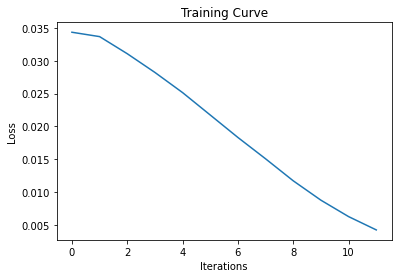

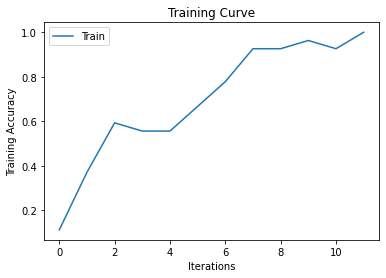

Final Training Accuracy: 1.0


In [80]:
CNN1 = CNN()
if use_cuda and torch.cuda.is_available():
  CNN1.cuda()

train_small(CNN1, num_epochs=20);

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# batch_size, learning rate and number of layers in CNN

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

epoch 1 | accuracy:  0.6879219804951238
epoch 2 | accuracy:  0.805701425356339
epoch 3 | accuracy:  0.9099774943735934
epoch 4 | accuracy:  0.9527381845461366
epoch 5 | accuracy:  0.9534883720930233
epoch 6 | accuracy:  0.9722430607651913
epoch 7 | accuracy:  0.9804951237809453
epoch 8 | accuracy:  0.9249812453113279
epoch 9 | accuracy:  0.9692423105776444
epoch 10 | accuracy:  0.9842460615153789
epoch 11 | accuracy:  0.9804951237809453
epoch 12 | accuracy:  0.9932483120780196
epoch 13 | accuracy:  0.9819954988747187
epoch 14 | accuracy:  0.9887471867966992
epoch 15 | accuracy:  0.9969992498124531
epoch 16 | accuracy:  0.9872468117029257
epoch 17 | accuracy:  0.9939984996249063
epoch 18 | accuracy:  0.9932483120780196
epoch 19 | accuracy:  0.978244561140285
epoch 20 | accuracy:  0.994748687171793


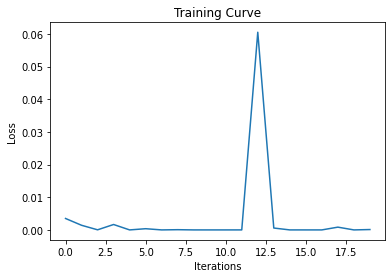

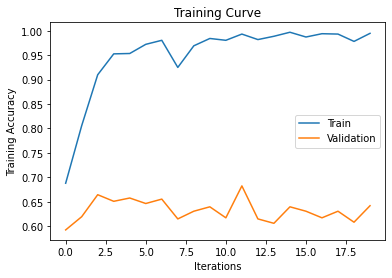

Final Training Accuracy: 0.994748687171793
Final Validation Accuracy: 0.6418918918918919


In [90]:
# 1. batch_size=128, num_epochs=20, learning_rate=0.001
CNN2 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN2.cuda()

train(CNN2, train_loader, val_loader)

epoch 1 | accuracy:  0.9962490622655664  | validation accuracy 0.6509009009009009
epoch 2 | accuracy:  0.9977494373593399  | validation accuracy 0.6373873873873874
epoch 3 | accuracy:  0.9992498124531133  | validation accuracy 0.6261261261261262
epoch 4 | accuracy:  0.9984996249062266  | validation accuracy 0.6396396396396397


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2566a133a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError: can only test a child process


epoch 5 | accuracy:  0.9977494373593399  | validation accuracy 0.6351351351351351
epoch 6 | accuracy:  0.9977494373593399  | validation accuracy 0.6463963963963963


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2566a133a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2566a133a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch 7 | accuracy:  0.994748687171793  | validation accuracy 0.6306306306306306


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2566a133a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch 8 | accuracy:  0.9969992498124531  | validation accuracy 0.668918918918919
epoch 9 | accuracy:  0.9849962490622656  | validation accuracy 0.6599099099099099
epoch 10 | accuracy:  0.9969992498124531  | validation accuracy 0.6554054054054054


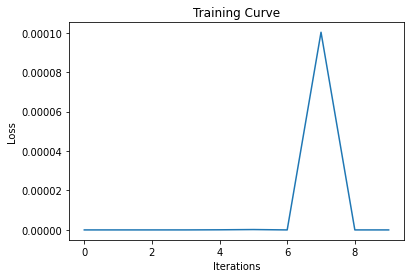

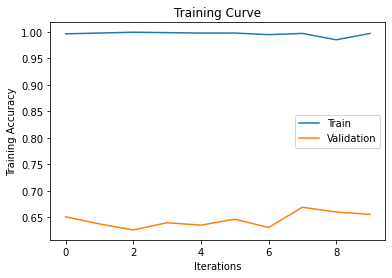

Final Training Accuracy: 0.9969992498124531
Final Validation Accuracy: 0.6554054054054054


In [96]:
# 2. Increase batch size
CNN3 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN3.cuda()

train(CNN3, train_loader, val_loader, batch_size = 256, num_epochs=10, learning_rate=0.001)

epoch 1 | accuracy:  0.12603150787696923  | validation accuracy 0.09684684684684684
epoch 2 | accuracy:  0.1245311327831958  | validation accuracy 0.10810810810810811
epoch 3 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 4 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 5 | accuracy:  0.11852963240810202  | validation accuracy 0.0990990990990991
epoch 6 | accuracy:  0.09902475618904726  | validation accuracy 0.11711711711711711
epoch 7 | accuracy:  0.11027756939234809  | validation accuracy 0.12387387387387387
epoch 8 | accuracy:  0.11027756939234809  | validation accuracy 0.12387387387387387
epoch 9 | accuracy:  0.10502625656414104  | validation accuracy 0.11486486486486487
epoch 10 | accuracy:  0.11852963240810202  | validation accuracy 0.0990990990990991


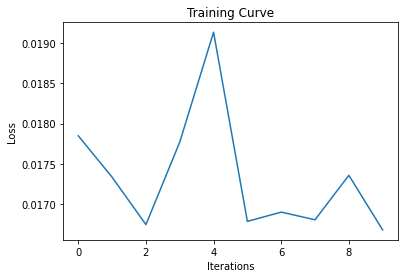

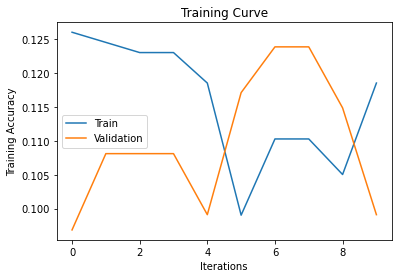

Final Training Accuracy: 0.11852963240810202
Final Validation Accuracy: 0.0990990990990991


In [97]:
# 3. Increase lreaning rate
CNN4 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN2.cuda()

train(CNN2, train_loader, val_loader, batch_size = 128, num_epochs=10, learning_rate=0.01)

In [100]:
class CNN_1(nn.Module):
    # My CNN has 3 convolutional layers and 2 fully connected layers
    # pooling layers are using max-pooling with size of 2x2
    # Using ReLU activation function

    def __init__(self):
        super(CNN_1, self).__init__()
        self.name = "CNN_1"
        self.conv1 = nn.Conv2d(3, 5, 5) #input channel = 3; output channel = 5; kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5) #input channel = 5; output channel = 10; kernel size = 5
        self.conv3 = nn.Conv2d(10, 20, 5) #input channel = 10; output channel = 20; kernel size = 5
        
        self.fc1 = nn.Linear(20 * 24 * 24, 32)
        self.fc2 = nn.Linear(32, 9) #32 hidden units, 9 outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 20 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

epoch 1 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 2 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 3 | accuracy:  0.10802700675168792  | validation accuracy 0.11036036036036036
epoch 4 | accuracy:  0.12003000750187547  | validation accuracy 0.10585585585585586
epoch 5 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 6 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 7 | accuracy:  0.11177794448612154  | validation accuracy 0.11711711711711711
epoch 8 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811
epoch 9 | accuracy:  0.11027756939234809  | validation accuracy 0.12387387387387387
epoch 10 | accuracy:  0.12303075768942236  | validation accuracy 0.10810810810810811


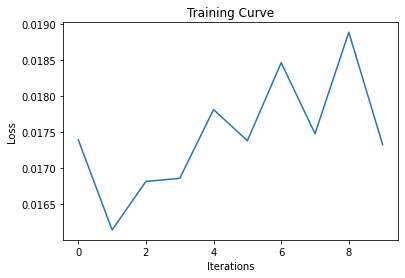

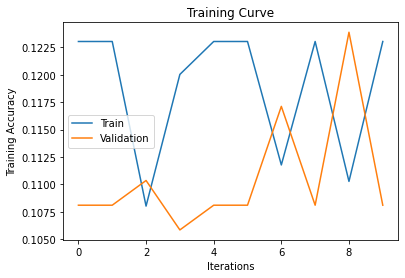

Final Training Accuracy: 0.12303075768942236
Final Validation Accuracy: 0.10810810810810811


In [101]:
# 4. Increase number of layers in CNN
CNN5 = CNN_1()
if use_cuda and torch.cuda.is_available():
    CNN5.cuda()

train(CNN5, train_loader, val_loader, batch_size = 128, num_epochs=10, learning_rate=0.01)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [102]:
# The best model is with batch_size = 256, num_epochs=10, learning_rate=0.001.
# Which have the best validation accuracy of 65.541%

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [105]:
def get_test_accuracy(model, test_loader):
    data = test_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [110]:
get_test_accuracy(CNN3, test_loader)

0.14382022471910114

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [111]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [171]:
import os

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


path = '/content/gdrive/MyDrive/Colab Notebooks/features'


In [172]:
def save_features(loader, path, datatype):
    n = 0
    if datatype == 'valid':
      subpath = '/valid'
    elif datatype == 'train':
      subpath = '/train'
    elif datatype == 'test':
      subpath = '/test'
    elif datatype == 'addition':
      subpath = '/addition'
    else: return

    for img, label in loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      folder_name = path + subpath
      folder_name = "/".join([folder_name, str(classes[label])])

      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

In [128]:
save_features(test_loader,path,'test')

In [129]:
save_features(val_loader,path,'valid')

In [130]:
save_features(train_loader,path,'train')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [133]:
train_dataset = torchvision.datasets.DatasetFolder(path + '/train', loader=torch.load, extensions=('.tensor'))
valid_dataset = torchvision.datasets.DatasetFolder(path + '/valid', loader=torch.load, extensions=('.tensor'))
test_dataset = torchvision.datasets.DatasetFolder(path + '/test', loader=torch.load, extensions=('.tensor'))

train_loader_new = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=1, shuffle=True)
val_loader_new = torch.utils.data.DataLoader(valid_dataset, batch_size=32, num_workers=1, shuffle=True)
test_loader_new = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

In [180]:
class CNN_AlexNet(nn.Module):
    def __init__(self):
        super(CNN_t, self).__init__()
        self.name = "CNN_t"
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 9) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  

In [ ]:
# My CNN module have only one layer and 1 maxpooling layer,
# the reason why I decrease the layer from 2 to 1 is that the feature of data have already been extracted by AlexNet model once.
# And I used Relu as activation function. 

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

epoch 1 | accuracy:  0.8537134283570893  | validation accuracy 0.7972972972972973
epoch 2 | accuracy:  0.9527381845461366  | validation accuracy 0.8828828828828829
epoch 3 | accuracy:  0.981245311327832  | validation accuracy 0.9121621621621622
epoch 4 | accuracy:  0.9894973743435859  | validation accuracy 0.9211711711711712
epoch 5 | accuracy:  0.9977494373593399  | validation accuracy 0.9256756756756757
epoch 6 | accuracy:  0.9984996249062266  | validation accuracy 0.9391891891891891
epoch 7 | accuracy:  0.9984996249062266  | validation accuracy 0.9346846846846847
epoch 8 | accuracy:  0.9984996249062266  | validation accuracy 0.9279279279279279
epoch 9 | accuracy:  0.9992498124531133  | validation accuracy 0.9414414414414415
epoch 10 | accuracy:  0.9932483120780196  | validation accuracy 0.9301801801801802


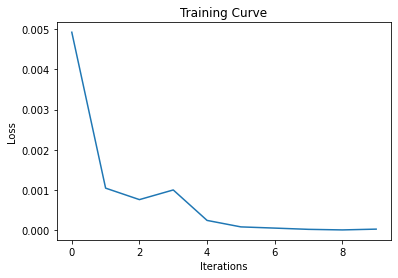

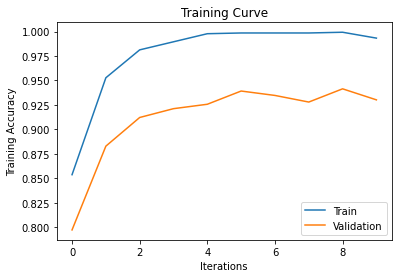

Final Training Accuracy: 0.9932483120780196
Final Validation Accuracy: 0.9301801801801802


In [135]:
AlexNet = CNN_AlexNet()
if use_cuda and torch.cuda.is_available():
  AlexNet.cuda()

train(AlexNet, train_loader_new, val_loader_new, batch_size=128, num_epochs=10)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [139]:
get_test_accuracy(AlexNet, test_loader_new)

0.9303370786516854

In [ ]:
# The test accuarcy of my best model is 0.9303
# which is much higher than the test accuracy i got before which is 0.14382

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [177]:
# data path of dataset
small_data_path = '/content/gdrive/MyDrive/Colab Notebooks/small_data'

# Transform Settings 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

small_dataset = torchvision.datasets.ImageFolder(root=small_data_path, transform=transform)
    
small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=1, num_workers=1, shuffle=True)

print(len(small_dataset))
print(len(small_loader))

27
27


In [178]:
path = '/content/gdrive/MyDrive/Colab Notebooks/features'

save_features(small_loader,path,'addition')

In [179]:
addition_dataset = torchvision.datasets.DatasetFolder(path + '/addition', loader=torch.load, extensions=('.tensor'))
addition_loader = torch.utils.data.DataLoader(addition_dataset, batch_size=27, num_workers=1, shuffle=True)

get_test_accuracy(AlexNet, addition_loader)

0.9259259259259259

In [ ]:
# The test accuracy on my sample images is 0.9259, which is a little low than the result 0.9303 from part4(d)
# This is expected since we are using way more images for training. But generally the model is working pretty well